# Installation

In [ ]:
#!pip install -U tensorflow-probability
!pip install -U tensorflow-addons

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfpd
import tensorflow_addons as tfa

# Dataset

## Functions

### Sample Dataset [sampleDataset()]

(<MapDataset shapes: {image: <unknown>, label: ()}, types: {image: tf.uint8, label: tf.int32}>,
 <MapDataset shapes: {image: <unknown>, label: ()}, types: {image: tf.uint8, label: tf.int32}>,
 <__main__. at 0x7f37d56b7850>)

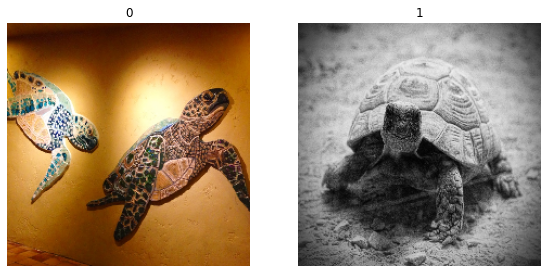

In [ ]:
import cv2
from urllib.request import urlopen

#IMG_SHAPE = (32, 32, 3)
IMG_SHAPE = (224, 224, 3)
N_CLASSES = 3

def get(url):
  with urlopen(str(url.numpy().decode("utf-8"))) as request:
      img_array = np.asarray(bytearray(request.read()), dtype=np.uint8)

  img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
  img = cv2.resize(img, IMG_SHAPE[:2], cv2.INTER_AREA)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def showExamples(ds, count=4):
  ds_itr = ds.as_numpy_iterator()
  plt.figure(figsize=(20, 20))

  for itemid in range(min(count, len(ds))):
    item = ds_itr.next()
    label = item['label']
    image = item['image']

    ax = plt.subplot(3, 4, itemid + 1)
    ax.set_title(label)
    plt.imshow(image)

    plt.axis("off")

def read_image_from_url(url, label):
  return {'image': tf.py_function(get, [url], tf.uint8), 'label': label}

def create_ds_info():
  supervised_keys = ('image', 'label')
  image = type("", (), dict(shape=IMG_SHAPE, dtype=tf.uint8))()
  label = type("", (), dict(shape=(), dtype=tf.int64, num_classes=N_CLASSES))()
  features = dict(image=image, label=label)
  train = type("", (), dict(shape=(), num_examples=2))()
  test = type("", (), dict(shape=(), num_examples=2))()
  splits = {'train': train, 'test': test}
  num_examples = splits['train'].num_examples + splits['test'].num_examples

  ds_info = type("", (), dict(features=features, total_num_examples=num_examples, splits=splits, supervised_keys=supervised_keys))()

  return ds_info

def sampleDataset():
  sample_urls = [
    'https://c4.staticflickr.com/8/7296/16386016665_53964c0bee_o.jpg',
    'https://farm3.staticflickr.com/4125/4983562261_1d7b59e36e_o.jpg',
    #'https://farm1.staticflickr.com/4141/4780447561_3959bc024b_o.jpg'
  ]

  dataset = tf.data.Dataset.from_tensor_slices((sample_urls, [0, 1]))
  dataset = dataset.map(read_image_from_url)

  ds_info = create_ds_info()
  showExamples(dataset)

  return dataset, dataset, ds_info

train_ds, test_ds, ds_info = sampleDataset()
train_ds, test_ds, ds_info

### Full Dataset [fullDataset()]

In [ ]:
def fullDataset():
  train_ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
  test_ds = tfds.load('cifar10', split='test')
  fig = tfds.show_examples(train_ds, ds_info)

  return train_ds, test_ds, ds_info

## Loading [train_ds, test_ds, ds_info]

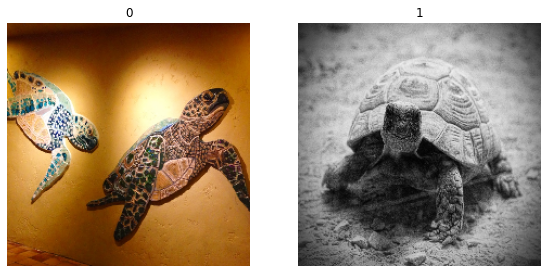

In [ ]:
train_ds, test_ds, ds_info = sampleDataset()

## Preprocessing [train_prep_ds, test_prep_ds]

In [ ]:
from functools import reduce

def dsitem_to_tuple(item):
  return (item['image'], item['label'])

def normalize_image(image, label):
  return tf.cast(image, tf.float32)/255, label

def onehot_encode(xvalue, label):
  return xvalue, tf.one_hot(tf.cast(label, tf.uint8), ds_info.features['label'].num_classes)

def prepfn(ds, funcs = [dsitem_to_tuple, onehot_encode]):
  return reduce(lambda y,x: y.map(x), funcs, ds)

train_prep_ds = prepfn(train_ds)
test_prep_ds = prepfn(test_ds)

test_prep_ds.as_numpy_iterator().next()

(array([[[107,  44,   0],
         [109,  48,   4],
         [104,  47,   2],
         ...,
         [ 83,  26,   0],
         [ 85,  25,   0],
         [ 88,  28,   2]],
 
        [[110,  46,   0],
         [107,  45,   2],
         [103,  44,   0],
         ...,
         [ 90,  31,   2],
         [ 92,  29,   1],
         [ 93,  28,   1]],
 
        [[109,  45,   0],
         [107,  46,   2],
         [104,  45,   1],
         ...,
         [ 91,  31,   0],
         [ 98,  35,   4],
         [ 99,  30,   1]],
 
        ...,
 
        [[145,  63,   1],
         [139,  56,   0],
         [147,  67,  10],
         ...,
         [152,  82,  17],
         [149,  82,  12],
         [143,  78,  10]],
 
        [[132,  55,   9],
         [122,  49,   3],
         [121,  44,   0],
         ...,
         [148,  78,  11],
         [146,  77,   8],
         [145,  76,   9]],
 
        [[124,  45,   0],
         [128,  54,   5],
         [126,  50,   1],
         ...,
         [142,  72,   4],
  

# Visualization [plot()]

In [ ]:
def labels_to_string(label):
  # Pick non-zero classes
  set_labels = [(i, v) for i, v in enumerate(label) if v != 0]
  
  return ' '.join("{0}:{1:.2f}".format(el[0], el[1]) for el in set_labels)

def plot(ds, count=4):
  ds_itr = ds.as_numpy_iterator()
  plt.figure(figsize=(20, 20))

  for itemid in range(min(count, len(ds))):
    image, label = ds_itr.next()

    ax = plt.subplot(3, 4, itemid + 1)
    #ax.set_title(labels_to_string(label))
    print(labels_to_string(label))
    plt.imshow(image)

    plt.axis("off")

# Model [get_model(), model]

In [ ]:
from tensorflow.keras import layers

def get_model():
  model = tf.keras.Sequential(
    [
        layers.Conv2D(16, (5, 5), activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, (5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.GlobalAvgPool2D(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
  )
  return model

model = get_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()
model.save_weights('initial_weights.h5')

# Transformations

## Functions [cutout()]

In [ ]:
IMG_SIZE,_,_ = ds_info.features['image'].shape

"""
  It computes a random offset for an area in the image.
  The size arg is the size of the target area.
"""
def rand_topleft_offsetfn(size):
  rand = tf.random.uniform(shape=(), dtype=tf.float32)
  max = tf.cast(IMG_SIZE - size, tf.float32)

  return tf.cast(rand*max, tf.int32)

def cutout(image, size):
  # Cutout offsets
  offset_h, offset_w = rand_topleft_offsetfn(size), rand_topleft_offsetfn(size)

  # Cutout center offset
  centerfn = lambda x: x + tf.cast(size/2, tf.int32) 
  center_h, center_w = centerfn(offset_h), centerfn(offset_w)

  # Apply the cutout
  batch = tf.expand_dims(image, axis=0)
  cut_batch = tfa.image.cutout(batch, (size, size), (center_h, center_w), 0) # tfa.image.cutout() cuts w.r.t. the center offsets.
  image = tf.squeeze(cut_batch, axis=0)

  return image, offset_h, offset_w

In [ ]:
image, label = train_prep_ds.as_numpy_iterator().next()
cutout(image, 40)

(<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
 array([[[107,  44,   0],
         [109,  48,   4],
         [104,  47,   2],
         ...,
         [ 83,  26,   0],
         [ 85,  25,   0],
         [ 88,  28,   2]],
 
        [[110,  46,   0],
         [107,  45,   2],
         [103,  44,   0],
         ...,
         [ 90,  31,   2],
         [ 92,  29,   1],
         [ 93,  28,   1]],
 
        [[109,  45,   0],
         [107,  46,   2],
         [104,  45,   1],
         ...,
         [ 91,  31,   0],
         [ 98,  35,   4],
         [ 99,  30,   1]],
 
        ...,
 
        [[145,  63,   1],
         [139,  56,   0],
         [147,  67,  10],
         ...,
         [152,  82,  17],
         [149,  82,  12],
         [143,  78,  10]],
 
        [[132,  55,   9],
         [122,  49,   3],
         [121,  44,   0],
         ...,
         [148,  78,  11],
         [146,  77,   8],
         [145,  76,   9]],
 
        [[124,  45,   0],
         [128,  54,   5],
         [126,

## Mixup [mixed_ds]

0:0.33 1:0.67


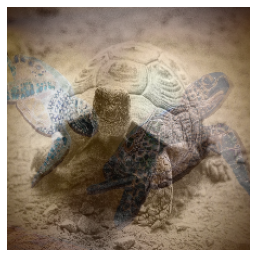

In [ ]:
ALPHA = 2

def value_mixup(v1, v2, lbda):
  # lbda*v1 + (1-lbda)*v2
  v = lbda*tf.cast(v1, tf.float32) + (1-lbda)*tf.cast(v2, tf.float32)
  return v

def mixup(item1, item2):
  image1, label1 = item1 # Unwrap the first sample
  image2, label2 = item2 # Unwrap the second sample

  # Sample the value ratios using a beta distribution.
  lbda = tfpd.distributions.Beta(ALPHA, ALPHA).sample()

  image = value_mixup(image1, image2, lbda) # Mix image data
  label = value_mixup(label1, label2, lbda)  # Mix labels

  return image, label

def cast_to_int(image, label):
  return tf.cast(image, tf.uint8), label


mixup_inputs = (
    train_prep_ds.shuffle(ds_info.splits['train'].num_examples),
    train_prep_ds
)
"""
# dataset is a preloaded tf.data.Dataset() object
mixup_inputs = (
    dataset.shuffle(ds_info.splits['train'].num_examples),
    dataset
)
"""

mixup_ds = tf.data.Dataset.zip(mixup_inputs)
mixed_ds = mixup_ds.map(mixup).map(cast_to_int)
plot(mixed_ds)

## CutMix [cutmixed_ds]

0:0.03 1:0.97
0:0.84 1:0.16


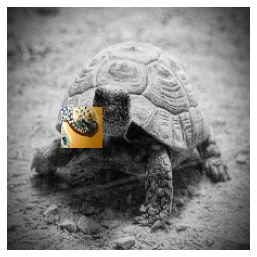

<Figure size 432x288 with 0 Axes>

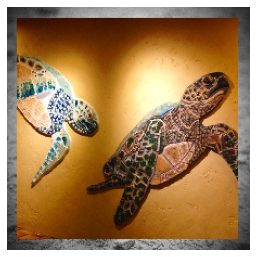

In [ ]:
IMG_SIZE,_,_ = ds_info.features['image'].shape
ALPHA = .2
BETA = .2

def cutmix(sample1, sample2):
  (image1, label1), (image2, label2) = sample1, sample2

  # Sample the cut area using a beta distribution.
  lbda = tfpd.distributions.Beta(ALPHA, BETA).sample()

  # Cutout limits
  min_cut_sizefn = lambda x: tf.math.maximum(x, 2) # Minimum cut-size is 2

  # Cutout dimensions
  cut_side_ratio = tf.math.sqrt(lbda)
  cut_size = tf.cast(IMG_SIZE * cut_side_ratio, tf.int32)
  cut_size = min_cut_sizefn(cut_size) # Apply cutout limits
  cut_size = tf.cast(cut_size / 2, tf.int32)*2 # Force even cutout size
  

  # Cutout offsets
  #offset_h, offset_w = rand_topleft_offsetfn(cut_size), rand_topleft_offsetfn(cut_size)

  # Clear the paste area from image1
  image, offset_h, offset_w = cutout(image1, cut_size)

  # Extract the cutout from image2
  cut = tf.image.crop_to_bounding_box(image2, offset_h, offset_w, cut_size, cut_size)

  # Expand the cutout to a full sized image
  cut_full = tf.image.pad_to_bounding_box(cut, offset_h, offset_w, IMG_SIZE, IMG_SIZE)

  # Paste the cutout
  image = image + cut_full

  # Construct the label
  label = (1 - lbda)*label1 + lbda*label2

  return image, label

cutmix_inputs = (
    train_prep_ds.shuffle(ds_info.splits['train'].num_examples),
    train_prep_ds
)

cutmix_ds = tf.data.Dataset.zip(cutmix_inputs)
cutmixed_ds = cutmix_ds.map(cutmix)

#image2, offset_h, offset_w, cut_size, cut_size = cutmixed_ds.as_numpy_iterator().next()
#print(image2, offset_h, offset_w, cut_size, cut_size)
#cut = tf.image.crop_to_bounding_box(image2, offset_h, offset_w, cut_size, cut_size)
#cut, target_offset_h, target_offset_w, IMG_SIZE, IMG_SIZE = cutmixed_ds.as_numpy_iterator().next()
#print(cut.shape, target_offset_h, target_offset_w, IMG_SIZE, IMG_SIZE)
#cut_full = tf.image.pad_to_bounding_box(cut, target_offset_h, target_offset_w, IMG_SIZE, IMG_SIZE)

plot(cutmixed_ds, 1)
plt.figure()
plot(cutmixed_ds, 1)

## CutOut

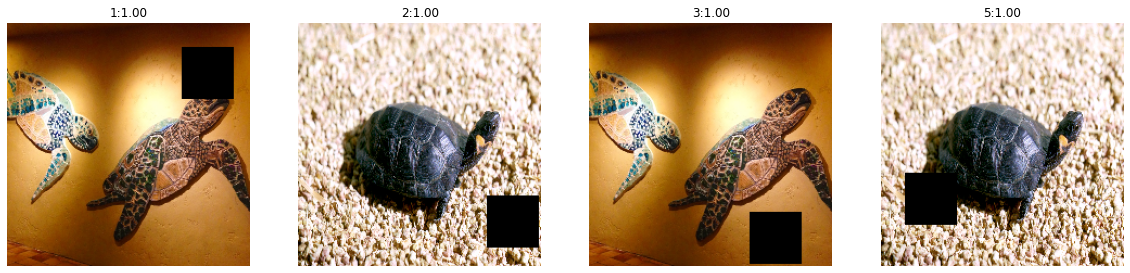

In [ ]:
import tensorflow_addons as tfa

CUTOUT_SIZE = 48
cutout_ds = train_prep_ds.map(lambda x,y: (cutout(x, CUTOUT_SIZE)[0], y))
plot(cutout_ds)

# Training

## Training Methods [train()]

In [ ]:
EPOCHS = 30
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = int(ds_info.splits['train'].num_examples/BATCH_SIZE)

test_batch_ds = test_prep_ds.batch(BATCH_SIZE)

def train(ds):
  batch_ds = ds.batch(BATCH_SIZE).shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True)
  model.fit(batch_ds, epochs=EPOCHS)

  _, test_acc = model.evaluate(test_batch_ds)
  print("Test accuracy: {:.2f}%".format(test_acc * 100))

## Regular

In [ ]:
model.load_weights('initial_weights.h5')
train(train_prep_ds)

## Mixup

In [ ]:
model.load_weights('initial_weights.h5')
train(mixed_ds)

## CutMix

In [ ]:
model.load_weights('initial_weights.h5')
train(cutmixed_ds)

In [ ]:
ALPHA = 1
BETA_DIST = tfpd.distributions.Beta(ALPHA, ALPHA)
BETA_DIST.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=0.795058>

In [ ]:
import tensorflow_addons as tfa

t = tf.random.uniform((1, 32, 32, 3))
print(t)

nt = tfa.image.cutout(t, (8, 8), [8, 8], 1)
tf.squeeze(nt, axis=0)